<a href="https://colab.research.google.com/github/kimdesok/UNet_2D_Semantic_Segmentation/blob/main/Unet_nuclear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Semantic Segmentation of Cellular Nuclei - UNet using Tensorflow 2
>* Dataset used in Kaggle's Data Science Bowl 2018 "Nuclei Segmentation"
>* The model architecture is the U-Net proposed by Olaf Ronneberger et al. [1] for biomedical image segmentation.
>* The original code is from Bengaluru, Karnatak [2] (based on an U-net starter - LB 0.277 by Kjetil Åmdal-Sævik)
>* Contour drawing is added to better visualize the nuclear boundary.

#References
[1] Olaf Ronneberger, Philipp Fischer, Thomas Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation https://arxiv.org/abs/1505.04597


[2] Tensorflow 2 - Nuclei Segmentation - UNet https://www.kaggle.com/advaitsave/tensorflow-2-nuclei-segmentation-unet/comments


In [ ]:
#%tensorflow_version 2.x

In [ ]:
#!pip uninstall tensorflow-gpu==2.0.0-alpha0
#!pip install tensorflow-gpu==2.0.0-alpha0

In [2]:
!mkdir input
%cd input
!mkdir stage_test
!mkdir stage_train
!mkdir stage_test_final
%cd ..

/content/input
/content


In [3]:
!unzip -q /content/drive/MyDrive/stage1_train.zip -d input/stage_train

In [4]:
!unzip  -q /content/drive/MyDrive/stage1_test.zip -d input/stage_test

In [27]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

In [ ]:
#!pip install -q git+https://github.com/tensorflow/examples.git

In [6]:
dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

In [7]:
#dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './input/stage_train/'
TEST_PATH = './input/stage_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

os.getcwd()

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

FINAL_TEST_PATH = './input/stage_test_final/'
final_test_ids = next(os.walk(FINAL_TEST_PATH))[1]

#Get the data
- Downsample both the training and test images to reduce computations.
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings.

In [8]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [07:38<00:00,  1.46it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 30.48it/s]

Done!


## Visualize the imported data

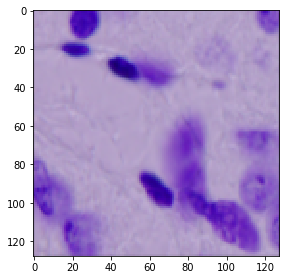

uint8


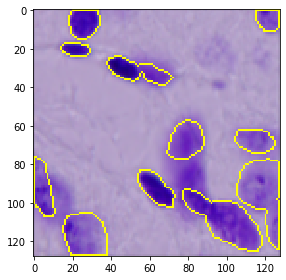

In [48]:
import cv2
from google.colab.patches import cv2_imshow

def contoured (im, maskim, color) :

  maskim = maskim.astype('uint8') * color
  # Dictionary giving RGB colour for label (segment label) - label 1 in red, label 2 in yellow
  RGBforLabel = {1:(255,0,0), 2:(0,255,0), 3:(255,255,0)}

  # Find external contours
  contours, _ = cv2.findContours(maskim, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # Iterate over all contours
  for i, c in enumerate(contours):
      # Find mean colour inside this contour by doing a masked mean
      mask = np.zeros(maskim.shape, np.uint8)
      cv2.drawContours(mask, [c], -1, 255, -1)
      # DEBUG: cv2.imwrite(f"mask-{i}.png",mask)
      mean,_,_,_ = cv2.mean(maskim, mask=mask)
      # DEBUG: print(f"i: {i}, mean: {mean}")

      # Get appropriate colour for this label
      #label = 2 if mean > 1.0 else 1
      colour = RGBforLabel.get(color)
      # DEBUG: print(f"Colour: {colour}")

      # Outline contour in that colour on main image, line thickness=1
      cv2.drawContours(im,[c],-1,colour,1)
  return im

# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))

cell_img = np.array(X_train[ix])
print(cell_img.dtype)

mask_img = np.squeeze(Y_train[ix])

cell_img = contoured(cell_img, mask_img, 3) #1:Red, 2:Green, 3:Yellow

imshow(cell_img)
plt.show()





# Build and train our neural network
- Build the U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) 
- very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [24]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [28]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [29]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [30]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [31]:
# Fit model
#earlystopper = EarlyStopping(patience=5, verbose=1)
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
#checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])
tf.to_int32=lambda x: tf.cast(x, tf.int32)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=[earlystopper, checkpointer])

Epoch 1/100
38/38 [==============================] - 37s 156ms/step - loss: 0.3435 - accuracy: 0.8530 - val_loss: 0.1637 - val_accuracy: 0.9361

Epoch 00001: val_loss improved from inf to 0.16370, saving model to model-dsbowl2018-1.h5
Epoch 2/100
38/38 [==============================] - 4s 103ms/step - loss: 0.1707 - accuracy: 0.9326 - val_loss: 0.1526 - val_accuracy: 0.9459

Epoch 00002: val_loss improved from 0.16370 to 0.15264, saving model to model-dsbowl2018-1.h5
Epoch 3/100
38/38 [==============================] - 4s 103ms/step - loss: 0.1414 - accuracy: 0.9461 - val_loss: 0.1436 - val_accuracy: 0.9499

Epoch 00003: val_loss improved from 0.15264 to 0.14355, saving model to model-dsbowl2018-1.h5
Epoch 4/100
38/38 [==============================] - 4s 104ms/step - loss: 0.1239 - accuracy: 0.9525 - val_loss: 0.1041 - val_accuracy: 0.9594

Epoch 00004: val_loss improved from 0.14355 to 0.10412, saving model to model-dsbowl2018-1.h5
Epoch 5/100
38/38 [==============================] 

#Prediction on train, validation, and test images

In [32]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 0s 179ms/step


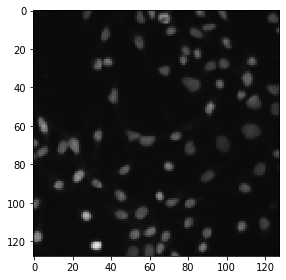

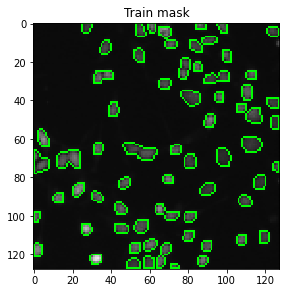

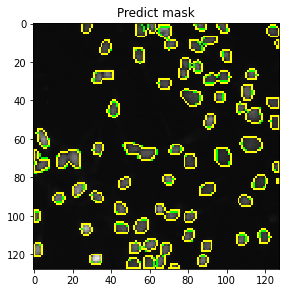

In [55]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()

im = contoured(X_train[ix], np.squeeze(Y_train[ix]), 2)
imshow(im)
plt.title('Train mask')
plt.show()

im = contoured(X_train[ix], np.squeeze(preds_train_t[ix]), 3)
imshow(im)
plt.title('Predict mask')
plt.show()

67 8


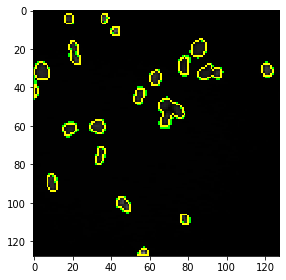

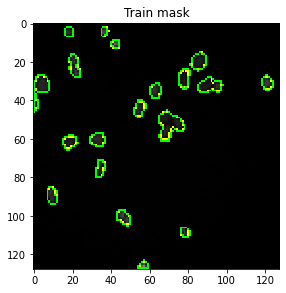

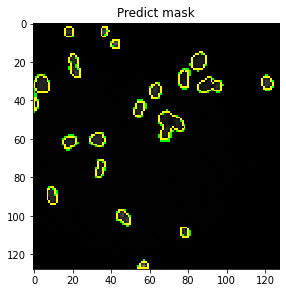

In [73]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
print(len(preds_val_t), ix)
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
im = contoured(X_train[int(X_train.shape[0]*0.9):][ix], np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]), 2)
imshow(im)
plt.title('Train mask')
plt.show()
im = contoured(X_train[int(X_train.shape[0]*0.9):][ix], np.squeeze(preds_val_t[ix]), 3)
imshow(im)
plt.title('Predict mask')
plt.show()